In [97]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasRegressor

In [98]:
df = pd.read_csv('../Real_Umbilo.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

,Q_entrada,NH_entrada,TSS_entrada,DQO_entrada,DBO_entrada,TN_entrada,TP_entrada,DQO_saida,Nitrato_saida,Amonia_saida
Dia,,,,,,,,,,
0,4719.000000,21.000000,271.000000,391.000000,198.575000,34.060000,8.020000,33.0,10.8,0.6
1,5866.458829,22.000327,276.000327,399.999347,203.059809,35.360294,8.099990,35.0,12.0,0.5
2,5358.157069,23.998870,281.996233,406.995103,206.957307,37.558734,8.149966,37.0,14.0,0.5
3,5266.313109,22.999791,278.000209,401.000418,203.710285,36.399787,8.109998,39.0,14.0,0.5
4,6671.931586,21.000432,274.999568,396.999136,201.824410,34.220441,8.060004,41.0,14.0,0.5
...,...,...,...,...,...,...,...,...,...,...
360,5120.341705,20.998558,184.998558,266.997116,135.395000,29.898501,6.929986,36.0,12.6,2.1
361,5587.915779,22.000000,182.001170,263.000000,134.093479,30.780012,6.900000,36.0,12.8,1.7
362,5984.690649,22.998229,179.999646,259.000354,131.495253,31.668215,6.869996,37.0,13.0,1.4


In [99]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Nitrato_saida',
            'Amonia_saida',
            'TP_entrada',
            'DQO_entrada',
            'DBO_entrada',], axis=1)

print("X", X.shape)
print("y", y.shape)

X (365, 4)
y (365,)


In [100]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (30, 4)
Test set y (30,)


In [101]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

## Reshaping is important for LSTM

In [102]:
# reshape input to be 3D [samples, timesteps, features]
train_X = normalized_x_train.values.reshape((normalized_x_train.values.shape[0], 1, normalized_x_train.values.shape[1]))
test_X = normalized_x_test.values.reshape((normalized_x_test.values.shape[0], 1, normalized_x_test.values.shape[1]))
print(train_X.shape, normalized_y_train.shape, test_X.shape, normalized_y_test.shape)

(335, 1, 4) (335,) (30, 1, 4) (30,)


In [103]:
val_X, val_y = train_X[305:335], normalized_y_train[305:335]
train_X, normalized_y_train = train_X[:305], normalized_y_train[:305]
y_train = y_train[:305]
print(val_X.shape, val_y.shape, train_X.shape, normalized_y_train.shape)

(30, 1, 4) (30,) (305, 1, 4) (305,)


Epoch 1/100
7/7 - 2s - loss: 0.6632 - val_loss: 0.5218 - 2s/epoch - 243ms/step
Epoch 2/100
7/7 - 0s - loss: 0.6301 - val_loss: 0.5317 - 32ms/epoch - 5ms/step
Epoch 3/100
7/7 - 0s - loss: 0.6027 - val_loss: 0.5497 - 70ms/epoch - 10ms/step
Epoch 4/100
7/7 - 0s - loss: 0.5970 - val_loss: 0.5646 - 32ms/epoch - 5ms/step
Epoch 5/100
7/7 - 0s - loss: 0.5774 - val_loss: 0.5820 - 28ms/epoch - 4ms/step
Epoch 6/100
7/7 - 0s - loss: 0.5790 - val_loss: 0.5903 - 27ms/epoch - 4ms/step
Epoch 7/100
7/7 - 0s - loss: 0.5695 - val_loss: 0.5801 - 28ms/epoch - 4ms/step
Epoch 8/100
7/7 - 0s - loss: 0.5592 - val_loss: 0.5681 - 30ms/epoch - 4ms/step
Epoch 9/100
7/7 - 0s - loss: 0.5633 - val_loss: 0.5685 - 24ms/epoch - 3ms/step
Epoch 10/100
7/7 - 0s - loss: 0.5585 - val_loss: 0.5722 - 27ms/epoch - 4ms/step
Epoch 11/100
7/7 - 0s - loss: 0.5513 - val_loss: 0.5826 - 25ms/epoch - 4ms/step
Epoch 12/100
7/7 - 0s - loss: 0.5572 - val_loss: 0.5873 - 29ms/epoch - 4ms/step
Epoch 13/100
7/7 - 0s - loss: 0.5594 - val_loss:

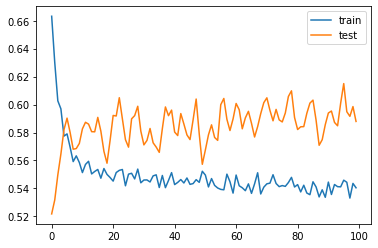

In [104]:
# design LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(16)) 
model.add(Dropout(0.1))
model.add(Dense(16))
model.add(Dropout(0.1))
model.add(Dense(16))
model.add(Dropout(0.1))

model.add(Dense(1)) #, kernel_initializer='uniform', activation='linear'
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, normalized_y_train, epochs=100, batch_size=50, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [105]:
# Realizando a predição no teste
y_test_pred_lstm = model.predict(test_X)

y_test_pred_lstm = np.array(y_test_pred_lstm).reshape(len(y_test_pred_lstm),1)
y_test_pred_lstm = scalery.inverse_transform(y_test_pred_lstm)
y_test_pred_lstm = pd.DataFrame(y_test_pred_lstm, columns=[normalized_y_test.name], index = normalized_y_test.index )
y_test_pred_lstm = y_test_pred_lstm.squeeze()

y_test_pred_lstm



# Análise dos erros das previsões
rmse_test_lstm = math.sqrt(mean_squared_error(y_test, y_test_pred_lstm))
mae_test_lstm = mean_absolute_error(y_test, y_test_pred_lstm)
mape_test_lstm = mean_absolute_percentage_error(y_test, y_test_pred_lstm)
r2_test_lstm = r2_score(y_test, y_test_pred_lstm)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_lstm], 'MAE':[mae_test_lstm], 'MAPE':[mape_test_lstm],'R²':[r2_test_lstm]})
df_metricas

1/1 [==============================] - 0s 274ms/step


,RSME,MAE,MAPE,R²
0,16.299322,12.042867,0.189259,0.55112


In [106]:
# plotar valor real vs valor predito

# Escrever a discussão dos resultados obtidos pelos diferentes métodos de machine learning
# comentando os resultados obtidos, por exemplo: "no modelo de regressão linear a importância
# do pH do tq2 foi muito alta, não parecendo refletir a realidade". Incluir meus questionamentos e dúvidas também
# Incluir as literaturas utilizada como base (referências). Comparar com resultados de outros problemas por outras pessoas.

In [107]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia

df_comparacao = pd.concat([y_test,y_test_pred_lstm],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

,Valor_Real,Valor_Predito,Diferenca_percentual
Dia,,,
335,75.0,76.381752,1.842336
336,92.0,86.937019,-5.503240
337,71.0,95.425598,34.402251
338,59.0,93.853577,59.073859
339,73.0,98.596695,35.063966
340,87.0,96.746323,11.202670
341,101.0,99.252594,-1.730105
342,126.0,77.796532,-38.256721
343,60.0,89.052681,48.421135


        RSME        MAE      MAPE       R²
0  16.299322  12.042867  0.189259  0.55112


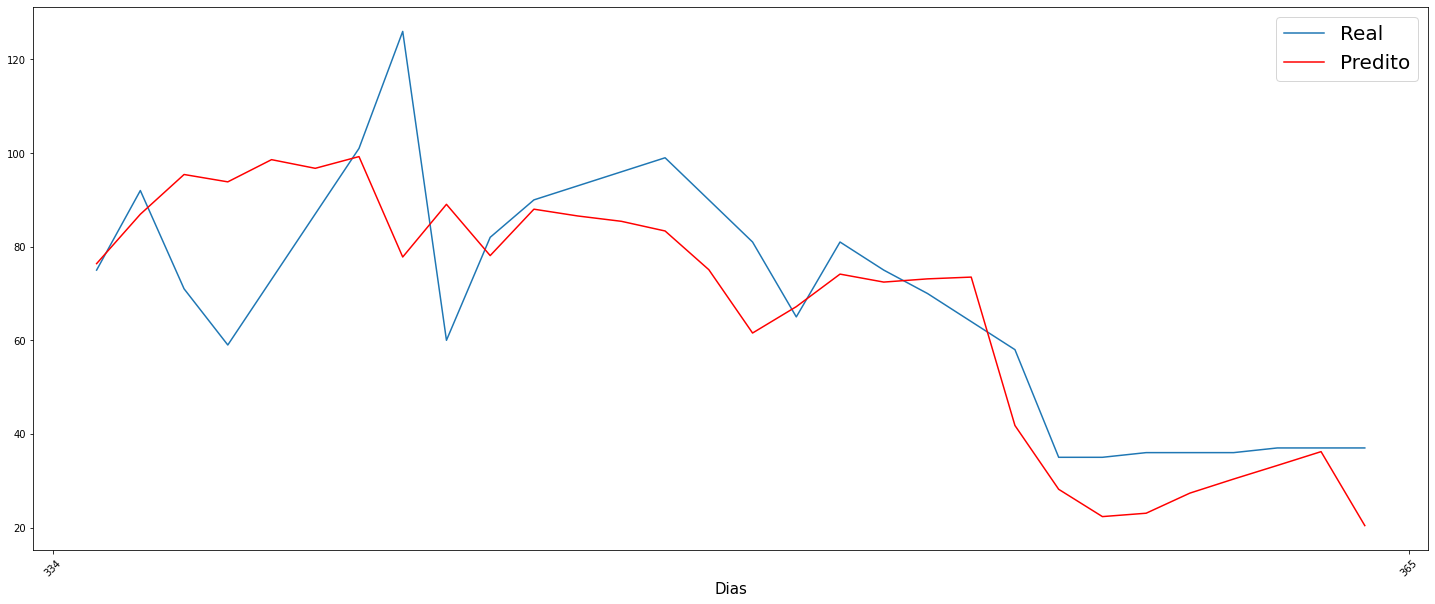

In [108]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

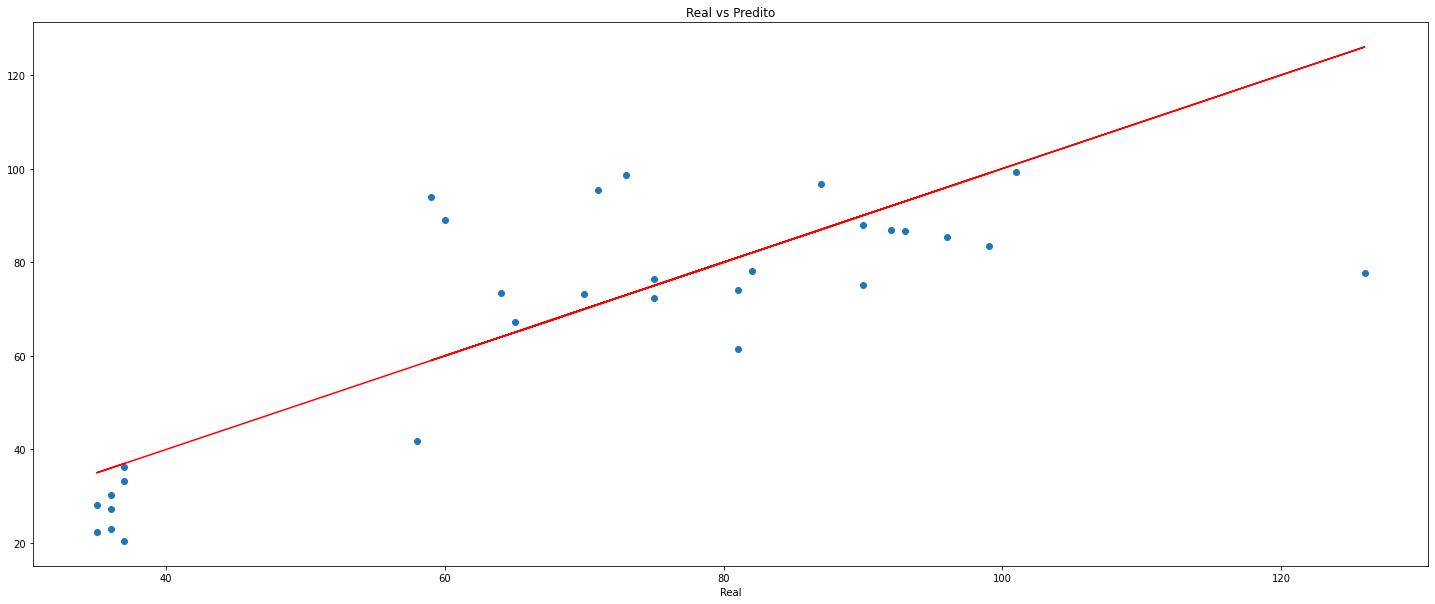

In [109]:
# Visualização gráfica das predições por valores reais
plt.figure(figsize=(25,10))
plt.title('Real vs Predito')
plt.scatter(df_comparacao['Valor_Real'], df_comparacao['Valor_Predito'])
plt.plot(df_comparacao['Valor_Real'],df_comparacao['Valor_Real'],c='r')
plt.xlabel('Previsto')
plt.xlabel('Real')
plt.show()

In [110]:
model.save("LSTM.h5")

In [111]:
# from keras.models import load_model

# model = load_model("LSTM.h5")

In [112]:
# Saving predictions

df_comparacao.to_csv("1-5-Previsoes_LSTM.csv", encoding='utf-8-sig',sep=';',decimal=',')

# Previsão na base de treino

10/10 [==============================] - 0s 1ms/step


        RSME        MAE      MAPE        R²
0  38.437075  21.561298  0.213576  0.142005


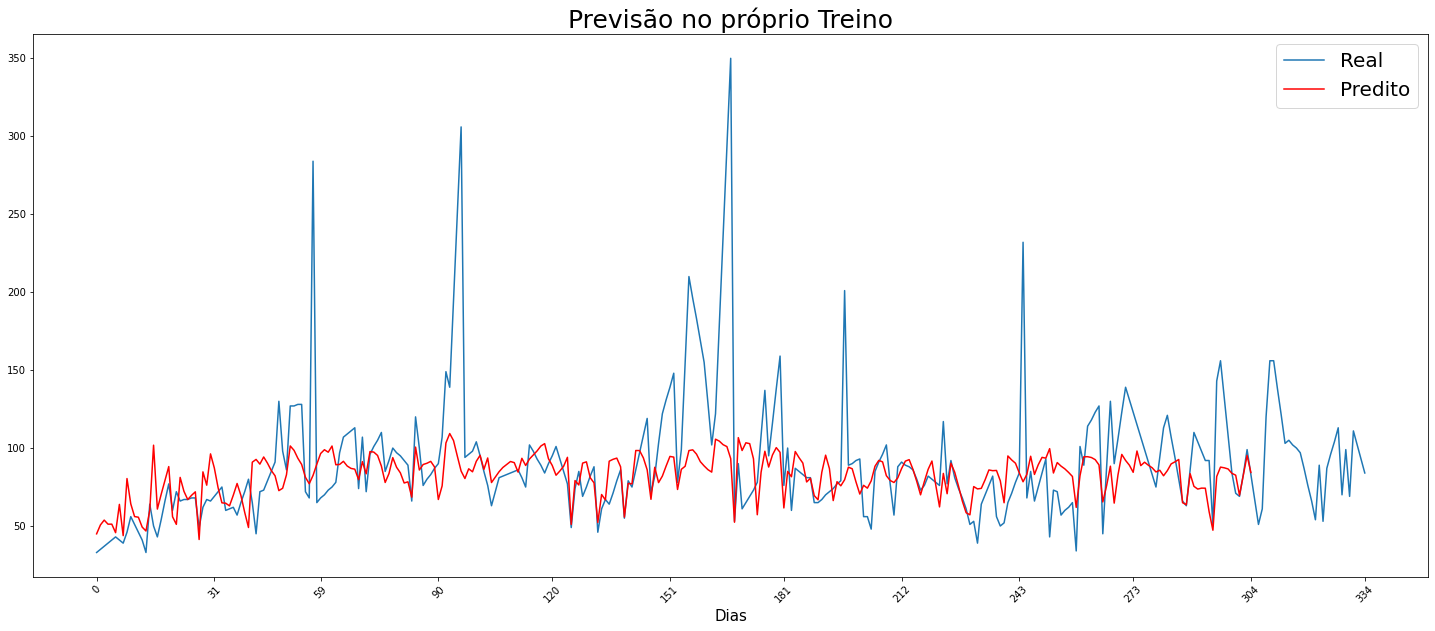

In [113]:
# Realizando a predição no traine
y_train_pred_mlp = model.predict(train_X)

# Desnormalização
y_train_pred_mlp = np.array(y_train_pred_mlp).reshape(len(y_train_pred_mlp),1)
y_train_pred_mlp = scalery.inverse_transform(y_train_pred_mlp)
y_train_pred_mlp = pd.DataFrame(y_train_pred_mlp, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_mlp = y_train_pred_mlp.squeeze()

y_train_pred_mlp


# Análise dos erros das previsões
rmse_train_mlp = math.sqrt(mean_squared_error(y_train, y_train_pred_mlp))
mae_train_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
mape_train_mlp = mean_absolute_percentage_error(y_train, y_train_pred_mlp)
r2_train_mlp = r2_score(y_train, y_train_pred_mlp)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_mlp],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_mlp], 'MAE':[mae_train_mlp], 'MAPE':[mape_train_mlp],'R²':[r2_train_mlp]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
plt.title('Previsão no próprio Treino', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [114]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_5-Previsoes_TREINO_LSTM.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [115]:
print(X_training.min())
print(X_training.max())

Q_entrada      3183.358416
NH_entrada        8.001139
TSS_entrada     150.178049
TN_entrada       22.240351
dtype: float64
Q_entrada      13259.856413
NH_entrada        68.927897
TSS_entrada     1033.632832
TN_entrada        88.642819
dtype: float64


In [116]:
# Calculate baseline metric
baseline_preds = model.predict(test_X)
baseline_metric = mean_squared_error(y_test, baseline_preds)

1/1 [==============================] - 0s 17ms/step


In [117]:
# Calculate feature importance via permutation importance
n_permutations = 30
feature_importance = np.zeros(test_X.shape[2])
for _ in range(n_permutations):
    for feature_idx in range(test_X.shape[2]):
        # Create a copy of the test set with shuffled values for the feature
        shuffled_test_X = test_X.copy()
        np.random.shuffle(shuffled_test_X[:, :, feature_idx])

        # Compute predictions and metric for the shuffled data
        shuffled_preds = model.predict(shuffled_test_X)
        shuffled_metric = mean_squared_error(y_test, shuffled_preds)

        # Calculate the feature importance for this permutation
        importance = baseline_metric - shuffled_metric
        feature_importance[feature_idx] += importance

# Average the feature importance over the permutations
feature_importance /= n_permutations

1/1 [==============================] - 0s 12ms/step


In [118]:
# Print the feature importances
for feature_idx, importance in enumerate(feature_importance):
    print(f"{df.columns[feature_idx]}: Importance = {abs(importance)}")

Q_entrada: Importance = 0.7431851623196962
NH_entrada: Importance = 6.577727293097329
TSS_entrada: Importance = 0.5800818485401275
DQO_entrada: Importance = 6.448291323692986


In [119]:
importance_df = pd.DataFrame(feature_importance,index=X.columns)
importance_df = importance_df.sort_values(by=0)
importance_df = importance_df/importance_df.sum()
importance_df

,0
TSS_entrada,-0.043982
Q_entrada,0.056348
TN_entrada,0.488910
NH_entrada,0.498724


In [120]:
importance_df.to_csv('3_5-Permutation_Importance_LSTM.csv',sep=';',decimal=',',encoding='utf-8-sig')

In [121]:
def calculate_pdp(feature_idx):
    # Select the feature for which you want to calculate the partial dependence
    selected_feature = train_X[:, :, feature_idx]

    # Create a grid of values for the selected feature
    grid_values = np.linspace(selected_feature.min(), selected_feature.max(), num=100)

    # Create a copy of the prepared dataset
    modified_data = np.copy(train_X)

    pdp_values = []
    
    # Replace feature values and generate predictions for each grid value
    for value in grid_values:
        modified_data[:, :, feature_idx] = value
        modified_predictions = model.predict(modified_data)

        # Calculate the average predictions
        average_predictions = np.mean(modified_predictions)

        pdp_values.append(average_predictions)

    return pdp_values

10/10 [==============================] - 0s 1ms/step


10/10 [==============================] - 0s 2ms/step


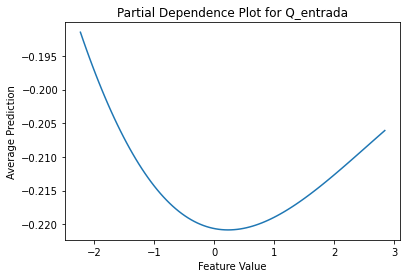

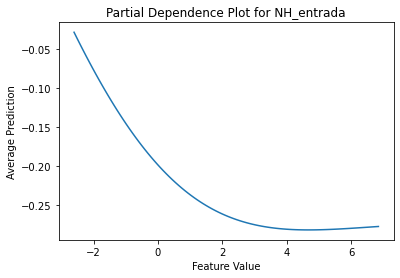

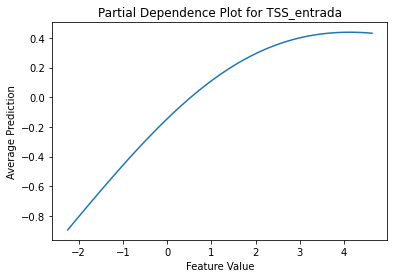

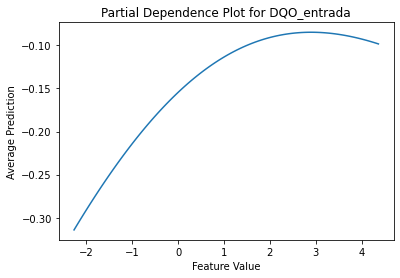

In [122]:
all_pdp_values = []
num_features = train_X.shape[2]  # Number of features in the data
pdp_intervals = []

# Calculate PDP values for all features
for feature_idx in range(num_features):
    pdp_values = calculate_pdp(feature_idx)
    all_pdp_values.append(pdp_values)
    
# Plot the PDPs for all features
for feature_idx, pdp_values in enumerate(all_pdp_values):
    grid_values = np.linspace(train_X[:, :, feature_idx].min(), train_X[:, :, feature_idx].max(), num=100)
    pdp_intervals.append(grid_values)
    
    plt.plot(grid_values, pdp_values)
    plt.xlabel('Feature Value')
    plt.ylabel('Average Prediction')
    plt.title('Partial Dependence Plot for {}'.format(df.columns[feature_idx]))
    plt.show()

In [123]:
# Values from each variable which have been used to calculate the PDPs
df_pdp_intervals = pd.DataFrame(pdp_intervals).T
df_pdp_intervals.columns = X.columns
df_pdp_intervals = df_pdp_intervals.add_suffix('_values')


# PDP values for each variable
df_pdp_values = pd.DataFrame(all_pdp_values).T
df_pdp_values.columns = X.columns
df_pdp_values = df_pdp_values.add_suffix('_importance')


# Interleave the columns from df_pdp_intervals and df_pdp_values
df_pdp = pd.concat([df_pdp_intervals, df_pdp_values], axis=1)
combined_columns = np.ravel(list(zip(df_pdp.columns[:df_pdp_intervals.shape[1]], df_pdp.columns[df_pdp_intervals.shape[1]:])))

# Rearrange the columns
df_pdp = df_pdp[combined_columns]

df_pdp.to_csv("4_5-PDPs_LSTM.csv",sep=';',decimal=',',encoding='utf-8-sig')

df_pdp

,Q_entrada_values,Q_entrada_importance,NH_entrada_values,NH_entrada_importance,TSS_entrada_values,TSS_entrada_importance,TN_entrada_values,TN_entrada_importance
0,-2.234546,-0.191485,-2.605314,-0.028704,-2.245832,-0.895374,-2.269600,-0.314128
1,-2.183303,-0.192809,-2.509903,-0.036633,-2.176382,-0.870504,-2.202552,-0.308228
2,-2.132061,-0.194100,-2.414493,-0.044447,-2.106932,-0.845662,-2.135504,-0.302391
3,-2.080819,-0.195357,-2.319082,-0.052146,-2.037483,-0.820857,-2.068456,-0.296619
4,-2.029576,-0.196581,-2.223672,-0.059726,-1.968033,-0.796095,-2.001408,-0.290912
...,...,...,...,...,...,...,...,...
95,2.633472,-0.207690,6.458689,-0.278734,4.351902,0.437376,4.099949,-0.094150
96,2.684714,-0.207287,6.554100,-0.278468,4.421352,0.436426,4.166996,-0.095153
97,2.735956,-0.206884,6.649510,-0.278202,4.490801,0.435238,4.234044,-0.096199
98,2.787199,-0.206482,6.744921,-0.277936,4.560251,0.433817,4.301092,-0.097289
